## Use case: Quantifying the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring

## Quality assessment question: "Is the dataset sufficiently accurate and consistent in terms of temporal and geographical coverage to effectively monitor and evaluate global (cumulative) glacier mass changes over time, including their associated impacts on global sea level rise?"

Glaciers are a major contributor to current global sea-level rise, a resource of fresh water, a potential threat of natural hazards, and an important factor for hydro-power production and runoff, as well as for recreation and tourism. A proper assessment of glacier mass changes due to warming climatic conditions therefore plays a crucial role in dealing with these issues. In that regard, the 'Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database' dataset provides key information with respect to glacier mass change data at various spatial and temporal scales. The dataset on the CDS is based on the Fluctuations of Glaciers (FoG) dataset (here we use version 2023-09), which are currently the most complete available datasets in terms of glacier mass changes, with a global coverage. It is a compilation of research data from in-situ, air and spaceborne methods (e.g. WGMS, 2022; Berthier et al., 2023), which have been put together and organized into one single gridded dataset. However, several known issues still persist in the dataset of which the user should take note before using the product. This notebook investigates how well the dataset can be used to quantify the link betwen glacier melt and glacier-related sea level contributions. More specifically, the notebook evaluates whether the dataset is of sufficient maturity and quality for that purpose in terms of its accuracy and consistency with respect to the temporal and geographical coverage (i.e. data completeness).

### Quality assessment statement

- The glaciers mass change dataset that is on the CDS is currently the most complete dataset of glacier mass change data in terms of its spatial coverage. It is generally considered the main reference dataset to determine the glaciers mass change across the globe.
- A quantitative pixel-by-pixel error estimate is available for the dataset. When checking these data, it can be seen that a decreasing trend with respect to mean overall glacier mass change uncertainties over time is present. During the earlier years of the dataset, overall average values (considered as an arithmetic mean over the entire globe) do not meet the minimum treshold proposed by the GCOS (GCOS, 2022). During the more recent years (after 2000 CE), the treshold is, however, met. Nevertheless, there is a high spatial heterogeneity of these uncertainty values. Especially peripheral glaciers of the Greenland and Antarctic ice sheets exhibit clearly too high uncertainty values.
- The data can be considered highly mature and complete in terms of its spatial and temporal coverage. Global glacierized areas and their trend over time, that are used as input data for the glacier mass change calculations, agree well with values from other reference datasets and numbers found in the literature. There are no data gaps in space and time.
- In other words, the dataset is found to be highly suitable to monitor and derive global (cumulative) mass changes over time and to, for example, assess the corresponding impact on global sea level changes in the context of Earth System modeling and climate change monitoring. The dataset has thus sufficient quality in terms of its accuracy (when compared to the minimum GCOS requirements, which is especially true during the more recent years and outside of the peripheral areas of Antarctica and Greenland) and its consistency with respect to spatial (i.e. global) and temporal (i.e. since 1975-76) coverage, as there are no data gaps. However, in order to calculate effective global sea level changes (i.e. to exclude glacier ice below sea level and floating glacier ice that does not contribute to global sea level changes), additional information is required for the user.
- When using the glacier mass change dataset that is available on the CDS, users should be aware of other typical problems with the dataset. One of such problems is the fact that data can not be consulted at the individual glacier-scale and that it is hence impossible to determine the number of sampled glaciers in a particular year for which mass or elevation changes and their error estimates are available. This lacking info can impact the quality and suitability of the data for similar glaciological, hydrological, and climatological applications, such as for example for the purpose of water resource managemt at the local (individual glaciers) scale. Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

### Methodology

#### Short description

The mass balance of a glacier is the difference between mass gained (from snow accumulation) and mass lost (by melting/runoff or ice discharge into lakes/the ocean), which is the same as the net mass change of a glacier. In general, the basis for the derived gridded mass changes are individual measurements (mainly glaciological in-situ annual surface mass balance data) and geodetic spaceborne elevation change data (an average elevation/ice thickness change or total annual ice volume change value), that are converted into an averaged specific mass balance value (i.e. for the entire glacier, mostly reported with units m w.e.) for every individual glacier. Afterwards, the data are submitted to the World Glacier Monitoring Service (WGMS). Further processing of the data results in a gridded (0.5° global grid) glacier mass change product with global coverage and dating back until the 1975-76 hydrological year. Each grid cell therefore contains a time series of total glacier mass change data (in Gt yr⁻¹ or m w.e. yr⁻¹) of all glaciers within the specific grid cell. In this notebook, we ue version 2023-09. For a more detailed description of the data acquisition and processing methods, we refer to the documentation on the CDS and the ECMWF Confluence Wiki.

#### Structure and (sub)sections

In this notebook, the applicability of glacier mass change data to quantify the link between glacier mass changes and global sea level contributions will be assessed. We will furthermore check whether the data are of sufficient accuracy and concistency in terms of its spatial/temporal coverage (i.e. data completeness) to be used for this purpose. This will be realized by analyzing the spatial and temporal characteristics of glacier mass change uncertainties, by assessing the spatial and temporal coverage of the dataset, by discussing other potential limitations and error sources of the dataset, and by evaluating the implications for the usage of the data in terms of the specific use case and question (i.e. quantifying glacier-related global sea level contributions). The structure is as follows:

- **Data preparation and processing**: This section loads packages, defines requests for download from the CDS, downloads the actual data and inspects the data to reveal its structure. Also the functions that are used in this notebook are defined in this section.
- **Quantifying global (cumulative) glacier mass changes since 1975-76**: This section derives annual and cumulative global glacier mass changes since 1975-76 and quantifies its total uncertainty throughout the time series using error propagation formulas.
- **Glacier mass changes and their uncertainty estimates in space and time**: This section further analyses the uncertainty term of the glacier mass product and assesses its characteristics in both space and time. The uncertainty is also compared to proposed tresholds by the GCOS Implementation Plan report (GCOS, 2022).
- **Analysis of spatio-temporal coverage of glacier mass changes**: This section discusses the temporal and geographical coverage of the data in the glacier mass change product. We compare the length of the time series, as well as values for the glacierized area (that are used as input for the glacier mass change calculations) and the trend over time, to values from other reference datasets and the literature. 
- **Quantification of glacier-related contributions to global sea level change**: The final section uses all information derived above to assess the suitability of the glacier mass change dataset (with respect to accuracy and consistency in terms of temporal and geographical coverage) to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring. 

## Analysis and results

### Data preparation and processing

First we load the packages:

In [398]:
import fsspec
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import rasterio.features
from rasterio.transform import from_origin
from scipy.stats import linregress
import os
os.environ["CDSAPI_RC"] = os.path.expanduser("~/verhaegen_yoni/.cdsapirc")
from c3s_eqc_automatic_quality_control import download

plt.style.use("seaborn-v0_8-notebook")

Then we define the parameters, i.e. for which years we want the glacier mass change data to be downloaded:

In [251]:
period_start = "1975_1976"
period_stop = "2021_2022"
assert all("_" in period and len(period) == 9 for period in (period_start, period_stop))

Then we define requests for download from the CDS and download and transform the glacier mass change data.

In [383]:
# Set request
y0_start, y1_start = map(int, period_start.split("_"))
y0_stop, y1_stop = map(int, period_stop.split("_"))
collection_id = "derived-gridded-glacier-mass-change"
request = {
    "variable": "glacier_mass_change",
    "product_version": "wgms_fog_2023_09",
    "format": "zip",
    "hydrological_year": [
        f"{y0}_{str(y1)[-2:]}"
        for y0, y1 in zip(range(y0_start, y0_stop + 1), range(y1_start, y1_stop + 1))
    ],
}

# Download glacier mass change data
print("Downloading glacier mass change data...")

ds = download.download_and_transform(
    collection_id,
    request,
)

print("Downloading done.")

100%|██████████| 1/1 [00:01<00:00,  1.82s/it]


For a more detailed analysis later in the notebook, we also download a land-sea mask and the surface geopotential (which can be thought of as a digital elevation model) from ERA5:

In [384]:
# Download surface orography from ERA5

print("Downloading orography from ERA5...")

request_era5 = (
    "reanalysis-era5-single-levels-monthly-means",
    {
        "product_type": "monthly_averaged_reanalysis",
        "variable": ["geopotential", "land_sea_mask"],
        "time": "00:00",
        "year": [2024],
        "month": [1],
        "time": "00:00",
        "grid": [0.5,0.5],
        "area": [np.max(ds["latitude"].values), np.min(ds["longitude"].values), np.min(ds["latitude"].values), np.max(ds["longitude"].values)],
        "format":"netcdf",
    },
)

# Get ERA5-Land data
ds_era5 = download.download_and_transform(*request_era5)
print("Download ERA5 completed.")

100%|██████████| 1/1 [00:00<00:00, 25.69it/s]

Download ERA5 completed.


Lastly, we can read and inspect the glacier mass change data. Let us print out the data to inspect its structure:

In [254]:
ds

<xarray.Dataset> Size: 487MB
Dimensions:                  (time: 47, latitude: 360, longitude: 720)
Coordinates:
  * time                     (time) datetime64[ns] 376B 1976-01-01 ... 2022-0...
  * latitude                 (latitude) float64 3kB 89.75 89.25 ... -89.75
  * longitude                (longitude) float64 6kB -179.8 -179.2 ... 179.8
Data variables:
    glacier_mass_change_gt   (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_mass_change_mwe  (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    glacier_area_km2         (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_gt           (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    uncertainty_mwe          (time, latitude, longitude) float64 97MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes:
    title:                 Global gridded annual glacier mass changes
    data_version:          version-wgms-fog-2023-09
    project:               Copernicus Climate Change Service (C3S) Essential ...
    institution:           World Glacier Monitoring Service - Geography Depar...
    created_by:            Dr. Ines Dussaillant - ines.dussaillant@geo.uzh.ch
    references:            Fluctuation of Glaciers (FoG) database version wgm...
    citation:              Dussaillant, I., Bannwart, J., Paul, F., Zemp, M. ...
    conventions:           CF Version CF-1.8
    dataset_description:   Horizontal resolution: 0.5° (latitude - longitude)...
    dataset_limitations:   Grid-point artefact in polar regions: see Algorith...
    dataset_improvements:  Improvements of product version WGMS-FOG-2023-09 w...
    comments:              Conversions between annual grid point mass change ...

It is a gridded dataset at a 0.5 by 0.5 degree spatial resolution containing annual values of the total glacier mass change (in Gt) of a grid cell (`glacier_mass_change_gt`) and its uncertainty (`uncertainty_gt`) since the 1975-76 hydrological year. Mass changes and their uncertainty can also be extracted in units of m water equivalent (`glacier_mass_change_mwe`). Note that not all grid cells exhibit the same absolute total surface area (glacierized and non-glacierized), as grid cells get smaller towards the poles. The parameterized absolute glacier surface area is furthermore also available in this dataset by the variabile `glacier_area_km2`. 

Let us perform some data handling before getting started with the analysis:

In [385]:
# Customize attributes in glacier mass change file
ds["time"] = ds["time"].dt.year
ds["time"].attrs |= {"long_name": "Time", "units": "yr"}
for da in ds.data_vars.values():
    da.attrs["units"] += " $yr^{-1}$"
    da.attrs["long_name"] = da.attrs["long_name"].replace("_", " ").title()

# Compute errors and add cumulative glacier mass change
ds_glacier_gt = ds["glacier_mass_change_gt"].sum(("latitude", "longitude"), keep_attrs=True)
ds_error_gt = ((ds['uncertainty_gt']) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5
ds_glacier_mwe = ds["glacier_mass_change_mwe"].mean(("latitude", "longitude"), keep_attrs=True)
ds_error_mwe = (((ds['uncertainty_mwe']) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5) * (1/(np.sqrt(np.sum(~np.isnan(ds["glacier_mass_change_mwe"].values)))))
ds_glacier_area_km2 = ds["glacier_area_km2"].sum(("latitude", "longitude"), keep_attrs=True)

annual_gt = ds_glacier_gt
annual_err_gt = ds_error_gt
cumulative_gt = ds_glacier_gt.cumsum("time")
cumulative_err_gt = ((ds_error_gt**2).cumsum("time")) ** 0.5
annual_mwe = ds_glacier_mwe
annual_err_mwe = ds_error_mwe
cumulative_mwe = ds_glacier_mwe.cumsum("time")
cumulative_err_mwe = ((ds_error_mwe**2).cumsum("time")) ** 0.5
annual_glacier_area = ds_glacier_area_km2

ds["Cumulative_gt"] = cumulative_gt
ds["Annual_gt"] = annual_gt
ds["Cumulative_error_gt"] = cumulative_err_gt
ds["Annual_error_gt"] = annual_err_gt
ds["Cumulative_mwe"] = cumulative_mwe
ds["Annual_mwe"] = annual_mwe
ds["Cumulative_error_mwe"] = cumulative_err_mwe
ds["Annual_error_mwe"] = annual_err_mwe
ds["Annual_area_km2"] = annual_glacier_area

# Get the orography and land-sea mask from ERA5
orography = (ds_era5["z"].mean(dim="time"))/9.80655
lsm = (ds_era5["lsm"].mean(dim="time"))

### Quantifying global (cumulative) glacier mass changes since 1975-76

In the following section, we plot the global annual (and cumulative) glacier mass change over time. For the annual values, we therefore sum the gridded mass change product over the entire spatial domain for each individual year to get values in Gt yr⁻¹, and calculate the arithmetic mean to get a value in m w.e. yr⁻¹:

$\Delta M_i 
$
[Gt yr⁻¹]
$ = \sum^{x,y}\Delta {M_{x,y}}$ where $\Delta {M_{x,y}}$ is the glacier mass change (in Gt yr⁻¹) at pixel $x,y$ during a certain year $i$, and

$\Delta M_i 
$
[m w.e. yr⁻¹]
$ = \frac{1}{n} \sum^{x,y}\Delta {M_{x,y}}$ where $\Delta {M_{x,y}}$ is the glacier mass change (in m w.e. yr⁻¹) at pixel $x,y$ during a certain year $i$ and $n$ is the total amount of pixels.


This results in the following plot:

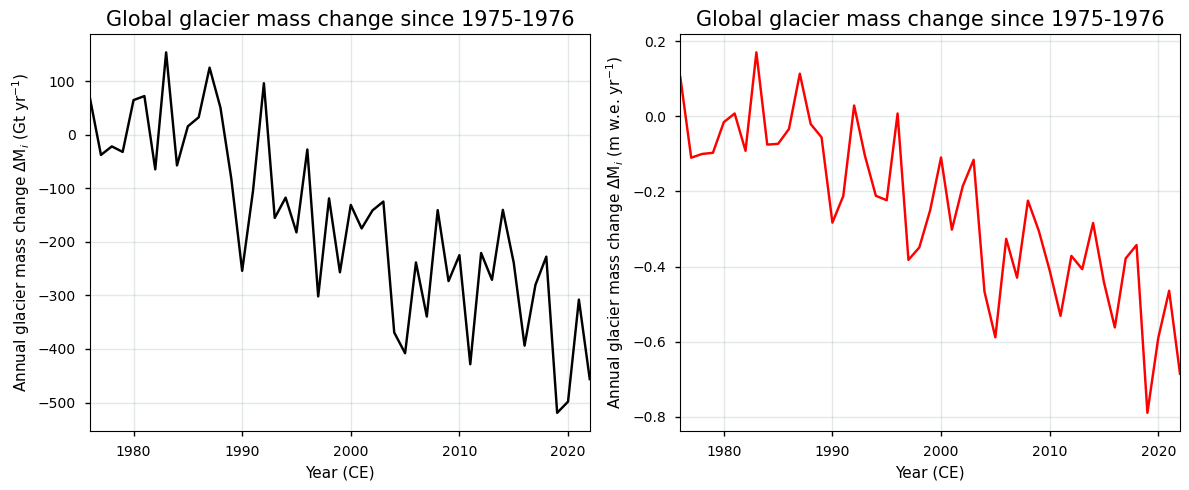

In [375]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_gt"].values,color='k')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel("Annual glacier mass change $\Delta$M$_i$ (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_mwe"].values,color='r')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Annual glacier mass change $\Delta$M$_i$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

The mass changes in the left plot above are expressed in Gt (Gigatonnes). Since Gt is a unit of mass, 1 Gt of ice weighs exactly the same as 1 Gt of water. The value can, however, also be translated into a volume. For example, 1 Gt of water (density 1000 kg/m³) is exactly 1 km³ water, while 1 Gt of ice (density 917 kg/m³) in volume becomes 1.091 km³ of ice. 

Quantitative pixel-by-pixel error estimates are also available for the dataset. The uncertainties that accompany the data come from different sources, of which the most important ones are the input data uncertainties, the density conversion for geodetic mass balances, errors related to absolute glacier area quantifications and their changes in space and time, possible data gaps, and spatio-temporal extrapolation and aggregation. All these processes and parameters play a key role in determining the final estimate of the glacier mass changes. The errors from these various sources are combined in the final product and the authors report these uncertainty values as being 1.96$\sigma$ (i.e. equivalent to a 95% confidence interval for a normal distribution). The corresponding annual global mass change uncertainty is calculated by assuming that errors are spatially uncorrelated and hence independent:

$
\sigma_{\Delta{M_{i}}} 
$
[Gt yr⁻¹]
$= \sqrt{\sum^{x,y}(\sigma_{ \Delta_{M_{x,y}}})^2}
$
, where $\sigma_{ \Delta_{M_{x,y}}}$ is the mass change error (in Gt yr⁻¹) at pixel $x,y$ during a certain year $i$, and

$
\sigma_{\Delta{M_{i}}} 
$
[m w.e. yr⁻¹]
$= \sqrt{\frac{1}{n}\sum^{x,y}(\sigma_{ \Delta_{M_{x,y}}})^2}
$
, where $\sigma_{ \Delta_{M_{x,y}}}$ is the mass change error (in m w.e. yr⁻¹) at pixel $x,y$ during a certain year $i$ and $n$ is the total amount of pixels with glacier mass change data (NaN pixels where no glaciers occur are excluded).

Plotting these data reveals the following:

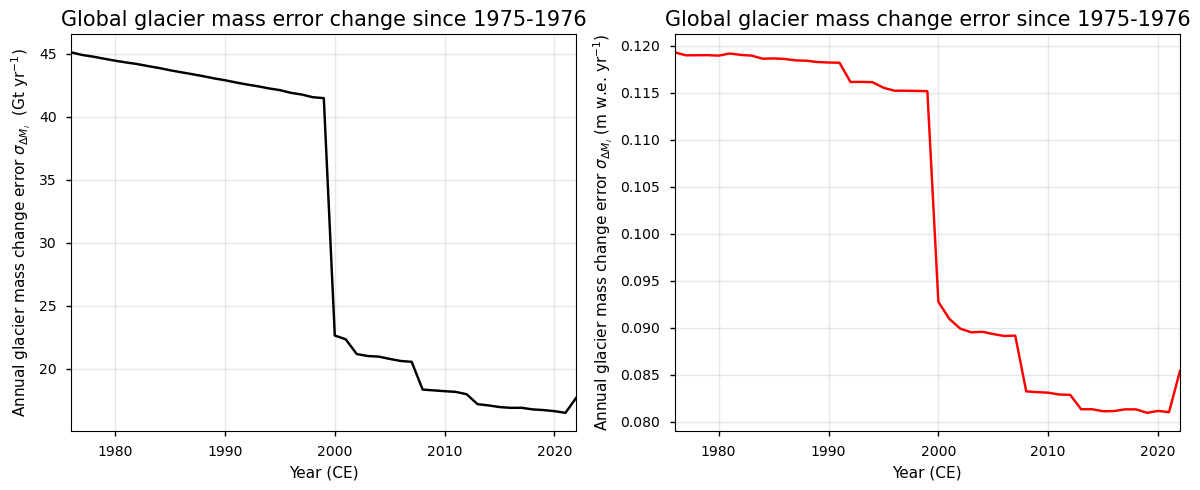

In [547]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.plot(ds["time"],ds["Annual_error_gt"].values,color='k')
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel("Annual glacier mass change error $\sigma_{\Delta{M_{i}}}$  (Gt yr$^{-1}$)")
ax1.set_title("Global glacier mass error change since "+ period_start.replace("_","-"),fontsize=15);
ax2.plot(ds["time"],ds["Annual_error_mwe"].values,color='r')
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Annual glacier mass change error $\sigma_{\Delta{M_{i}}}$ (m w.e. yr$^{-1}$)")
ax2.set_title("Global glacier mass change error since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

It can be seen from the plot that the global glacier mass change uncertainty has been decreasing over time, from ca. 40-45 Gt in the beginning of the dataset to ca. 15-20 Gt during the more recent hydrological years, with a sudden drop around 2000 CE. 

The data can also be plotted in a cumulative way:

$
\Delta{M} 
$
$
= \sum_{i={1976}}^{{{n}}} (\Delta M_{i})
$
, where $\Delta {M_{i}}$ is the global glacier mass change (in Gt yr⁻¹ or m w.e. yr⁻¹) at a certain year $i$ (as calculated above) and $n$ the number of years in the time series.

The corresponding uncertainty is again calculated by assuming uncorrelated errors:

$
\sigma_{\Delta{M}}
$
$
= \sqrt{\sum_{i={1976}}^{{n}} (\sigma_{\Delta{M_{i}}})^2}
$
, where $\sigma_{\Delta{M_{i}}}$ is the global mass change uncertainty (in Gt yr⁻¹ or m w.e. yr⁻¹) at a certain year $i$ (as calculated above).

The corresponding plot looks as follows:

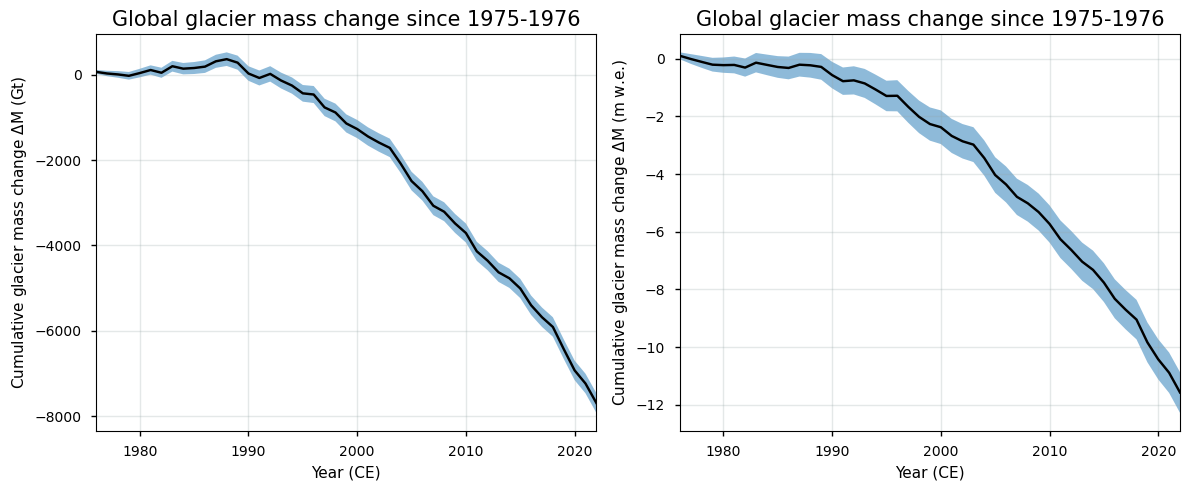

In [380]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
line1 = ds["Cumulative_gt"]
error1 = ds["Cumulative_error_gt"]
ax1.fill_between(line1["time"], line1 - error1, line1 + error1, alpha=0.5)
line1.plot(ax=ax1, color="k")
ax1.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax1.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax1.set_xlabel("Year (CE)")
ax1.set_ylabel("Cumulative glacier mass change $\Delta$M (Gt)")
ax1.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
line2 = ds["Cumulative_mwe"]
error2 = ds["Cumulative_error_mwe"]
ax2.fill_between(line2["time"], line2 - error2, line2 + error2, alpha=0.5)
line2.plot(ax=ax2, color="k")
ax2.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax2.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax2.set_xlabel("Year (CE)")
ax2.set_ylabel("Cumulative glacier mass change $\Delta$M (m w.e.)")
ax2.set_title("Global glacier mass change since "+ period_start.replace("_","-"),fontsize=15);
plt.tight_layout()
plt.show()

From the image above, it can be seen that glaciers clearly have been losing mass during the observational period, especially since the 1990s. The final estmate of the glaciers mass change at the end of the time series is:

In [259]:
print(f"The total global cumulative glacier mass change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line2.values[-1]:.2f} ± {error2.values[-1]:.2f} m w.e. or {line1.values[-1]:.2f} ± {error1.values[-1]:.2f} Gt.")

The total global cumulative glacier mass change between 1975-1976 and 2021-2022 is -11.58 ± 0.71 m w.e. or -7691.70 ± 230.53 Gt.


### Glacier mass changes and their uncertainty estimates in space and time

Let us explore a bit more the uncertainty of the data. We will change the units to kg m⁻² yr⁻¹ because the GCOS Implementation Plan report (GCOS, 2022) advises uncertainty values to be provided in these units: 

$
\sigma_{\Delta{M}}
$
[kg m⁻² yr⁻¹] = 
$
\frac{1*10^{12} * \sigma_{\Delta{M}}}{1*10^6 * A_{glacier}} = 1*10^{6} * (\frac{\sigma_{\Delta{M}}}{A_{glacier}})
$
where $\sigma_{\Delta{M}}$ is the mass change uncertainty at pixel $x,y$ and time $i$ [Gt yr⁻¹] from `uncertainty_gt` and $A_{glacier}$ the glacier surface area in km² from `glacier_area_km2`.

We can plot a histogram of the error term over all pixels and all years to inspect its distribution:

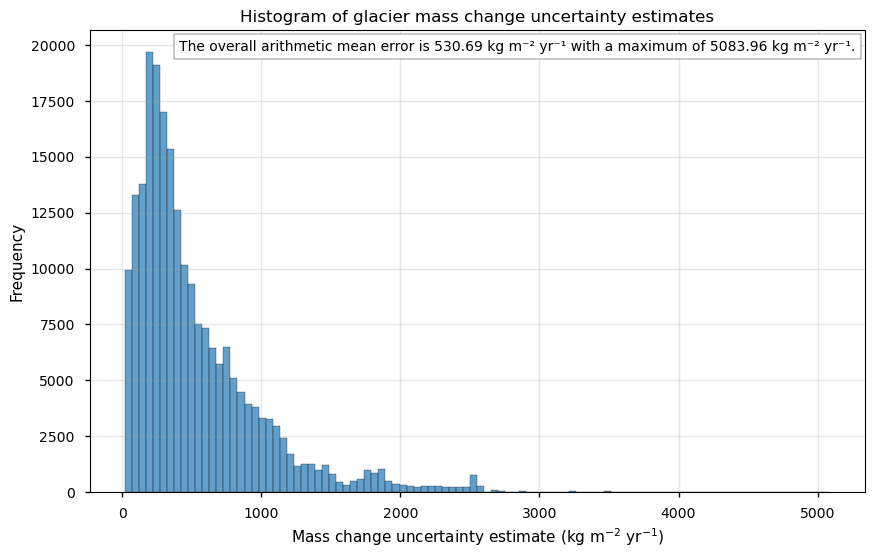

In [367]:
plt.figure(figsize=(10, 6))
error_kg_m2_yr = (1e6*ds['uncertainty_gt'].values.flatten()) / (ds['glacier_area_km2'].values.flatten())
plt.hist(error_kg_m2_yr, bins=100, edgecolor='black', alpha=0.7)
plt.title('Histogram of glacier mass change uncertainty estimates')
plt.xlabel('Mass change uncertainty estimate (kg m$^{-2}$ yr$^{-1}$)')
plt.ylabel('Frequency')
plt.grid(color='#95a5a6',linestyle='-',alpha=0.25)
_ = plt.text(
    -0.057,
    0.520,
    f"The overall arithmetic mean error is {np.nanmean(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9 with a maximum of {np.nanmax(error_kg_m2_yr):.2f} kg m\u207B² yr\u207B\u00B9.",
    transform=ax.transAxes,
    bbox={"facecolor": "white", "edgecolor": "black"},
);
plt.show()

The overall artihmetic mean error over both space and time seems small, and the majority of errors seem to be situated close to 200-500 kg m⁻² yr⁻¹. Further investigation reveals that the errors do not exhibit a significant relationship with the glacier surface area nor with the absolute magnitude of the mass change in the corresponding pixels:

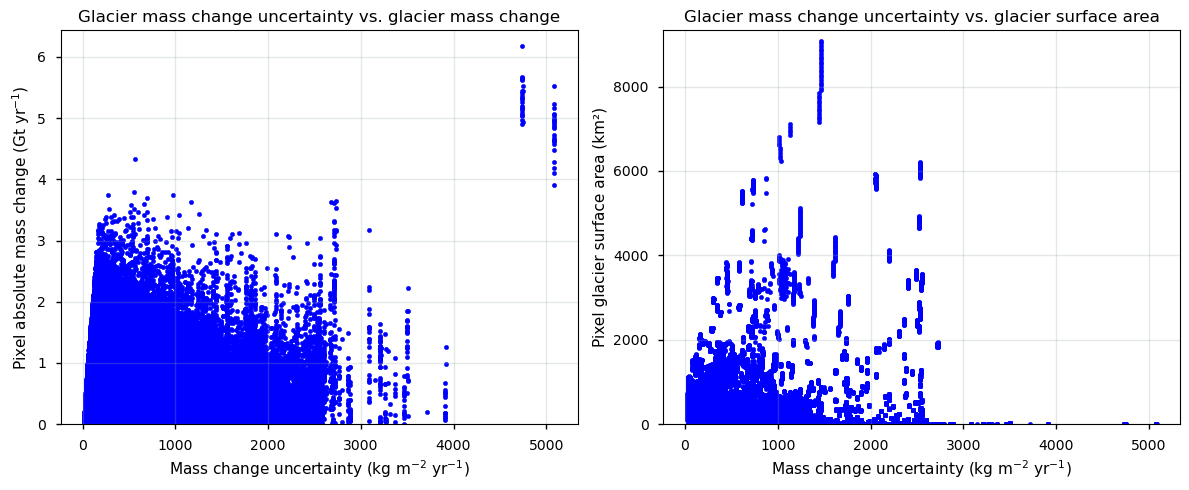

In [452]:
# Flatten the matrices to 1D arrays
x = error_kg_m2_yr
y1 = ds['glacier_mass_change_mwe'].values.flatten()
y2 = ds['glacier_area_km2'].values.flatten()

# Plot the data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First scatter plot
ax1.scatter(x, abs(y1), color='b', s=10)
ax1.set_title('Glacier mass change uncertainty vs. glacier mass change')
ax1.set_xlabel('Mass change uncertainty (kg m$^{-2}$ yr$^{-1}$)')
ax1.set_ylabel('Pixel absolute mass change (Gt yr$^{-1}$)')
ax1.set_ylim(0, np.nanmax(abs(ds['glacier_mass_change_mwe']))+0.25)
ax1.grid(color='#95a5a6', linestyle='-', alpha=0.25)

# Second scatter plot
ax2.scatter(x, y2, color='b',s=10)
ax2.set_title('Glacier mass change uncertainty vs. glacier surface area')
ax2.set_xlabel('Mass change uncertainty (kg m$^{-2}$ yr$^{-1}$)')
ax2.set_ylabel('Pixel glacier surface area (km²)')
ax2.set_ylim(0, np.nanmax(ds['glacier_area_km2'])+250)
ax2.grid(color='#95a5a6', linestyle='-', alpha=0.25)

# Display the plots
plt.tight_layout()
plt.show()

As an extra step, we can calculate the overall arithmetic mean glacier mass change error for each hydrological year to get a general idea of the overall magnitude of the errors. This is simply calculated as the spatial arithmetic mean of all pixels for each year $i$:

$\overline{\sigma_{\Delta{M_{x,y}}}}  
$
[m w.e. yr⁻¹]
$ = \frac{1}{n} \sum^{{{x,y}}} (\sigma_{\Delta{M_{x,y}}})$ where $\Delta {M_{x,y}}$ is the glacier mass change (in m w.e. yr⁻¹) at pixel $x,y$ and $n$ is the total amount of pixels (NaN pixels with no glaciers excluded).

This results in the following:

In [274]:
# Calculate area-weighted mean error for each year
mean_error_per_year = []

for t in ds['time']:
    errors = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).sel(time=t).values
    
    # Flatten the arrays to perform the weighted mean calculation
    errors_flat = errors.flatten()
    
    # Calculate the area-weighted mean error
    mean_error = np.nanmean(errors_flat)
    mean_error_per_year.append(mean_error)

# Convert to a numpy array or xarray DataArray if needed
mean_error_per_year = np.array(mean_error_per_year)

# Print or use the area-weighted mean errors per year
for year, error1 in zip(ds['time'].values, mean_error_per_year):
    print(f"The overall spatial mean glacier mass change error for the year {year-1}-{year-1900 if year<2000 else (year-2000):0>2} is {error1:.2f} kg m⁻² yr⁻¹.")

The overall spatial mean glacier mass change error for the year 1975-76 is 607.35 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1976-77 is 605.18 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1977-78 is 605.33 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1978-79 is 605.20 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1979-80 is 604.47 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1980-81 is 606.96 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1981-82 is 605.20 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1982-83 is 604.42 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1983-84 is 601.39 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error for the year 1984-85 is 601.47 kg m⁻² yr⁻¹.
The overall spatial mean glacier mass change error

The threshold (i.e. the minimum requirement to be met to ensure that data are useful) for glacier mass change uncertainty (expressed in terms of 2$\sigma$) proposed by the GCOS is 500 kg m⁻² yr⁻¹, while the breakthrough value (i.e. the level at which specified uses within climate monitoring become possible) would be 200 kg m⁻² yr⁻¹ per grid point (GCOS, 2022). It can be noted that for the earlier years, the error values (reported as 1.96$\sigma$) consistently slightly exceed the threshold of 500 kg m⁻² yr⁻¹, which suggests relatively high uncertainty in the dataset. This potentially limits its applicability for certain purposes. During the more recent years, the error values remain below this threshold, but do not exhibit values particularly closer to or below the breakthrough value of 200 kg m⁻² yr⁻¹ per grid point. However, there is a decreasing trend in the overall mean error, indicating slightly more reliable data with an imporoved suitability for climate monitoring and related applications. The dataset's error values thus meet the the threshold value proposed by GCOS only during the more recent years. This suggests that the dataset has relatively high uncertainty levels, potentially hindering certain applications and requiring further assessment or improvement to meet GCOS requirements.

At last, let us check the spatial distribution of the mean overall error over time per grid point, which is simply calculated as the temporal arithmetic mean over all years for each pixel $x,y$:

$\overline{\sigma_{\Delta{M_{i}}}}  
$
[m w.e. yr⁻¹]
$ = \frac{1}{n} \sum_{i={1976}}^{{{n}}} (\sigma_{\Delta{M_{i}}})$ where $\Delta {M_{i}}$ is the glacier mass change (in m w.e. yr⁻¹) in year $i$ and $n$ is the total amount of years in the time series.

This results in the following:

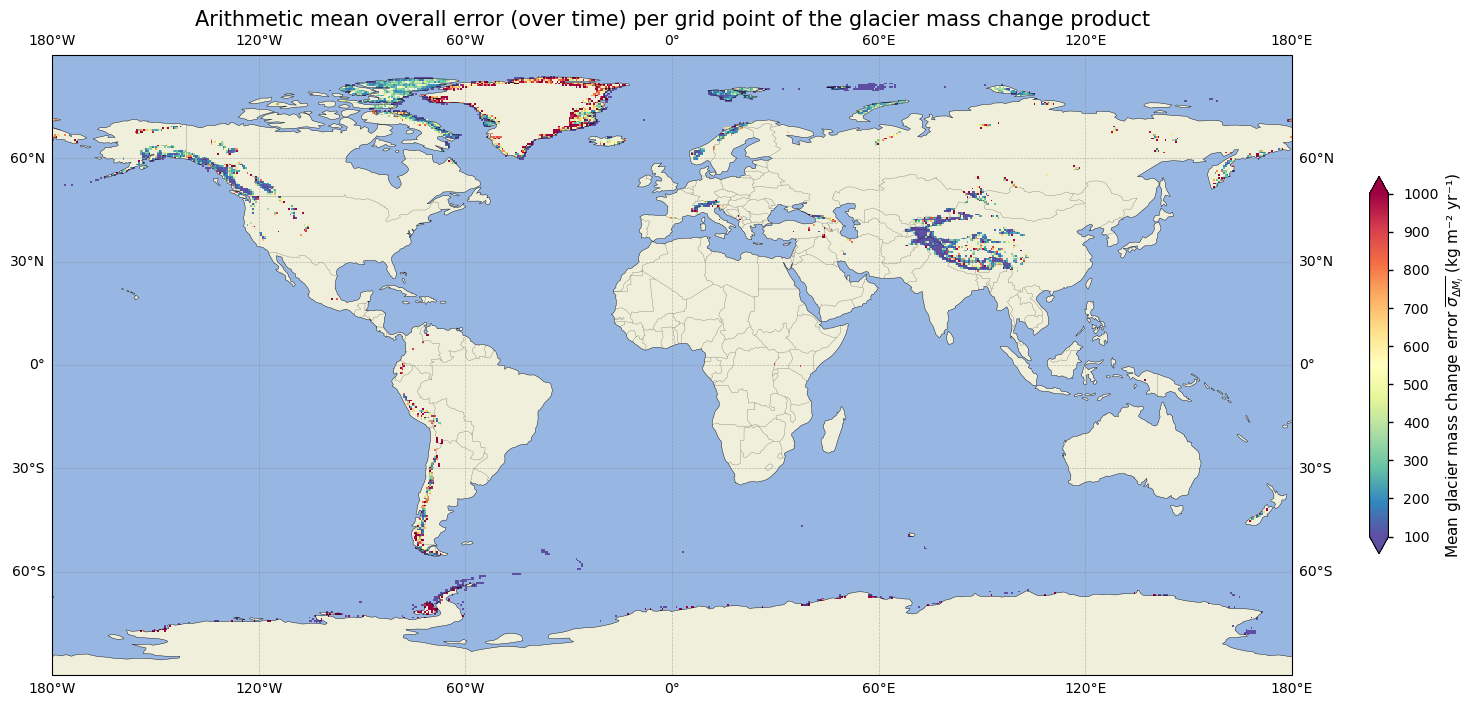

In [465]:
# Plot the gridded data
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig=plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS,linewidth=0.25,alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
         linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
im=ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, transform=ccrs.PlateCarree(), cmap = mpl.cm.Spectral_r, vmin=100,vmax=1000)
fig.colorbar(im,ax=ax,extend='both',shrink=0.49,label='Mean glacier mass change error $\overline{\sigma_{\Delta{M_{i}}}}$ (kg m⁻² yr⁻¹)')
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product',fontsize=15)
plt.show()

The errors seem to be especially high in the peripheral glaciers and ice caps of the Greenland and Antarctic ice sheets, as well as in the southern Andean region. In these regions, the threshold value of 500 kg m⁻² yr⁻¹ is not reached. Let us make this plot a bit clearer by grouping these errors with respect to the threshold values proposed by the GOCS:

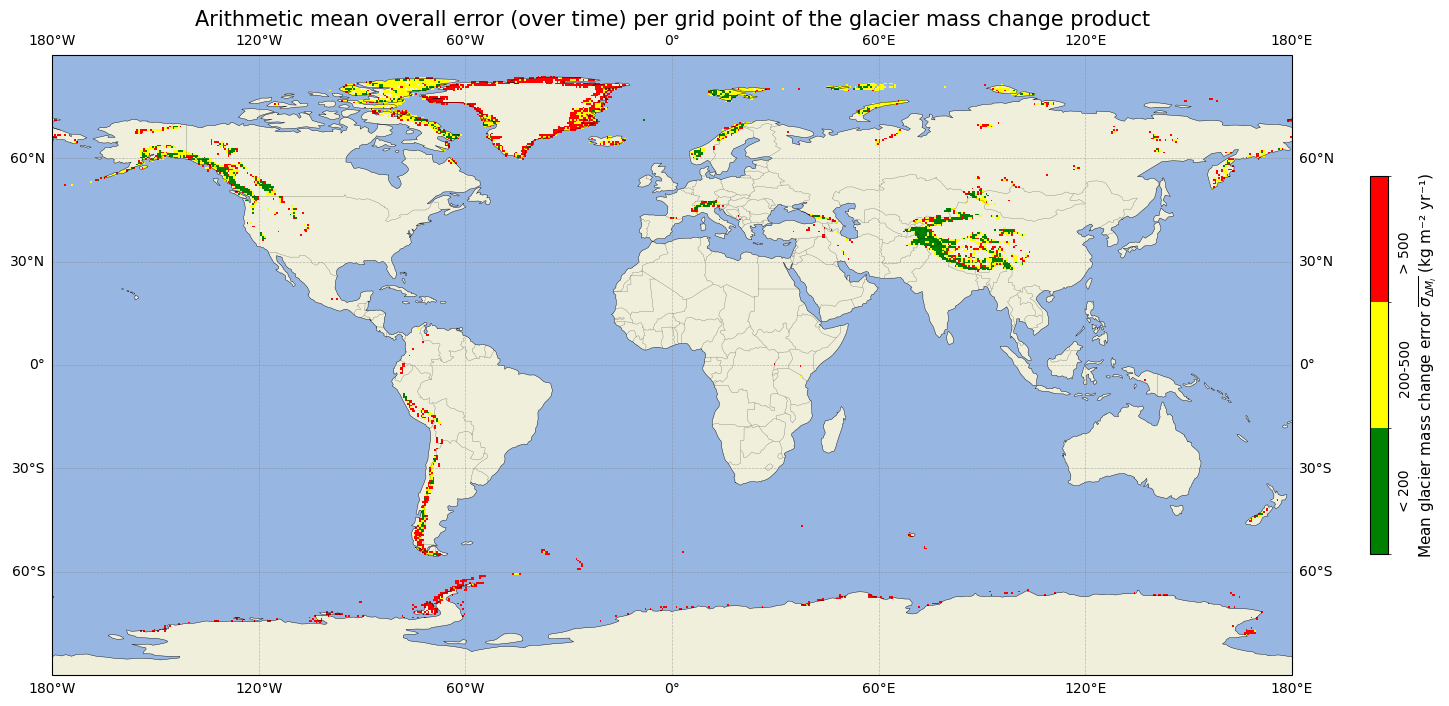

In [455]:
# Define the boundaries for the colorbar
bounds = [0, 200, 500, np.nanmax(error_spatial)]
cmap = mpl.colors.ListedColormap(['green','yellow', 'red'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
error_spatial = (1e6 * ds['uncertainty_gt'] / ds['glacier_area_km2']).mean(("time"), keep_attrs=True)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, error_spatial, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Mean glacier mass change error $\overline{\sigma_{\Delta{M_{i}}}}$ (kg m⁻² yr⁻¹)', spacing="uniform")
cb.set_ticks([(0+250)/2, (200+600)/2, (650+np.nanmax(error_spatial))/2])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels(['< 200', '200-500', '> 500'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Arithmetic mean overall error (over time) per grid point of the glacier mass change product', fontsize=15)
plt.show()

Green pixels indicate areas where the breakthrough value of (an uncertainty of 200 kg m⁻² yr⁻¹ or lower), as proposed by the GCOS, has been reached, whereas red grid points exhibit temporally arithmetic mean error values that exceed the threshold value (500 kg m⁻² yr⁻¹ or more) for the data to be useful. This confirms our statement from above: especially the Greenland and Antarctic peripheral glaciers and parts of the Andes exhibit error values that are clearly too high. Extra care from the user is required in these regions since the threshold value has not been reached. Other regions, such as High Mountain Asia and the majority of Alaskan and European glaciers, have accuracy values that allow for a reliable and high-quality data analysis. Possible reasons for this pattern are the following:

- Sparse data coverage: Glaciers in Greenland and Antarctica often have sparse in-situ data coverage compared to glaciers in other regions. Monitoring these regions can be challenging due to their remote and harsh environments, leading to fewer observational data points and less accurate measurements.
- Complex terrain and dynamics: Glaciers in Greenland and Antarctica are typically characterized by complex terrain and dynamics, and separation of outlet glaciers from the main ice sheet body remains difficult. Satellite observations may furthermore have limitations in accurately capturing glacier mass changes in these polar regions due to factors such as cloud cover and snow accumulation, leading to higher error values in mass change estimates. Also, processes such as firn densification and vertical bed rock motion complicate the volume (from elevation changes) to mass conversion. 
- Gridded data limitations: Due to the 0.5 degree spatial resoltuion, individual glaciers can be larger than the grid surface in polar regions. This can additionally introduce errors in the mass change estimation. 

Let us quantify the percentage of data (over all pixels and all years) that do and do not reach the threshold values:

In [371]:
error_spatial = (1e6*ds['uncertainty_gt']/ds['glacier_area_km2'])
count_200 = (error_spatial < 200).sum().values
count_500 = (error_spatial > 500).sum().values
count_nonnan = np.sum(~np.isnan(error_spatial).values)
print(f"The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is {(100*count_200/count_nonnan):.2f}%.")
print(f"The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is {(100*count_500/count_nonnan):.2f}%.")

The percentage of data points with a glacier mass change error value less than 200 kg m⁻² yr⁻¹ is 21.79%.
The percentage of data points with a glacier mass change error value more than 500 kg m⁻² yr⁻¹ is 38.36%.


A quantification of the errors and an analysis of the spatio-temporal distribution of these errors thus reveals interesting results. This info can be useful for the suitability of the data for various applications in cryospheric monitoring and related fields, such as quantifying the glacier-related contributions to global sea level change. Let us further assess the quality of the data by checking its spatio-temporal coverage.

### Analysis of spatio-temporal coverage of glacier mass changes

To assess the spatio-temporal coverage of the data, we can make use of the `glacier_area_km2` variable within the dataset. Let us plot the global glacierized area over time to get an idea of how this variable looks:

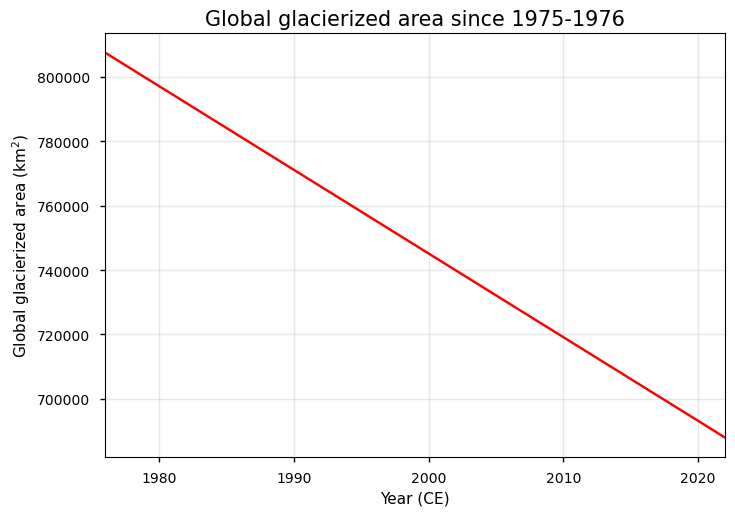

In [391]:
fig, ax = plt.subplots()
ax.plot(ds["time"],ds["Annual_area_km2"],'r')
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global glacierized area (km$^2$)")
ax.set_title("Global glacierized area since "+ period_start.replace("_","-"),fontsize=15);plt.show()

As can be seen from the plot above, the glacierized area results from a linear decrease over time. It is hence not derived from in-situ and/or remote sensing data, but rather inserted into the data as a parameterization. For proper assessment, we can compare the value around 2000 CE to that of the 'Glaciers distribution data from the Randolph Glacier Inventory (RGI) for year 2000' dataset, which is 746088.28 km$^2$ from the vector (shape file) product in RGI v6.0 (RGI Consortium, 2017):

In [396]:
print(f"The total global glacierized area in the glacier mass change dataset in 2000 CE is {ds['Annual_area_km2'].sel(time=2000).compute().item():.2f} km², which is {100*(ds['Annual_area_km2'].sel(time=2000).compute().item())/(746088.28):.2f}% of the area in the RGIv6.0 dataset.")

The total global glacierized area in the glacier mass change dataset in 2000 CE is 745153.82 km², which is 99.87% of the area in the RGIv6.0 dataset.


The value of the linear trend can also be easily computed. This can then be compared to values in the literature to evaluate its accuracy:

In [402]:
slope, intercept, r_value, p_value_trend, std_err = linregress(ds["time"], ds['Annual_area_km2'])
relative_area_change = ds['Annual_area_km2'] / ds['Annual_area_km2'].isel(time=0) * 100
slope_rel, intercept_rel, r_value_rel, p_value_trend_rel, std_err_rel = linregress(ds['time'], relative_area_change)
print(f"The linear trend of glacier area changes over time in the glacier mass change dataset between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {(slope):.2f} km² yr⁻¹ or {(slope_rel):.2f} % yr⁻¹.")

The linear trend of glacier area changes over time in the glacier mass change dataset between 1975-1976 and 2021-2022 is -2600.53 km² yr⁻¹ or -0.32 % yr⁻¹.


Just like the absolute glacierized area around 2000 CE, also the number of the linear trend above compares well with values from Zemp et al. (2019), who estimate the global glacierized area change to be -0.34% yr⁻¹ between 1961-2016 when considered at the global scale. However, a linear decrease of the glacierized areas may not be the best parameterization to consider in some regions. Many studies namely have reported recent accelerations of glacier retreat and shrinkage. This is, amongst others, the case in the Himalaya (Maurer et al., 2019), the Caucasus (Tielidze et al., 2022), western Canada (Bevington and Menounos, 2022), and the Altai Mountains (Chang et al., 2022). A linear trend may thus not be appropriate in these regions and may underestimate glacier area losses that are inserted into the glacier mass change calculation. 

To have an idea of the temporal coverage, we can plot the number of years that hold non-NaN mass change data for each pixel. If the pixel exhibits complete temporal coverage, the value should equal the number of years in the time dimension `time` of the dataset. In the map below, pixels where the time series of glacier mass change data has an amout of non-NaN values that equal the number of years in the time dimension of the data array are colored green, else they are colored red:

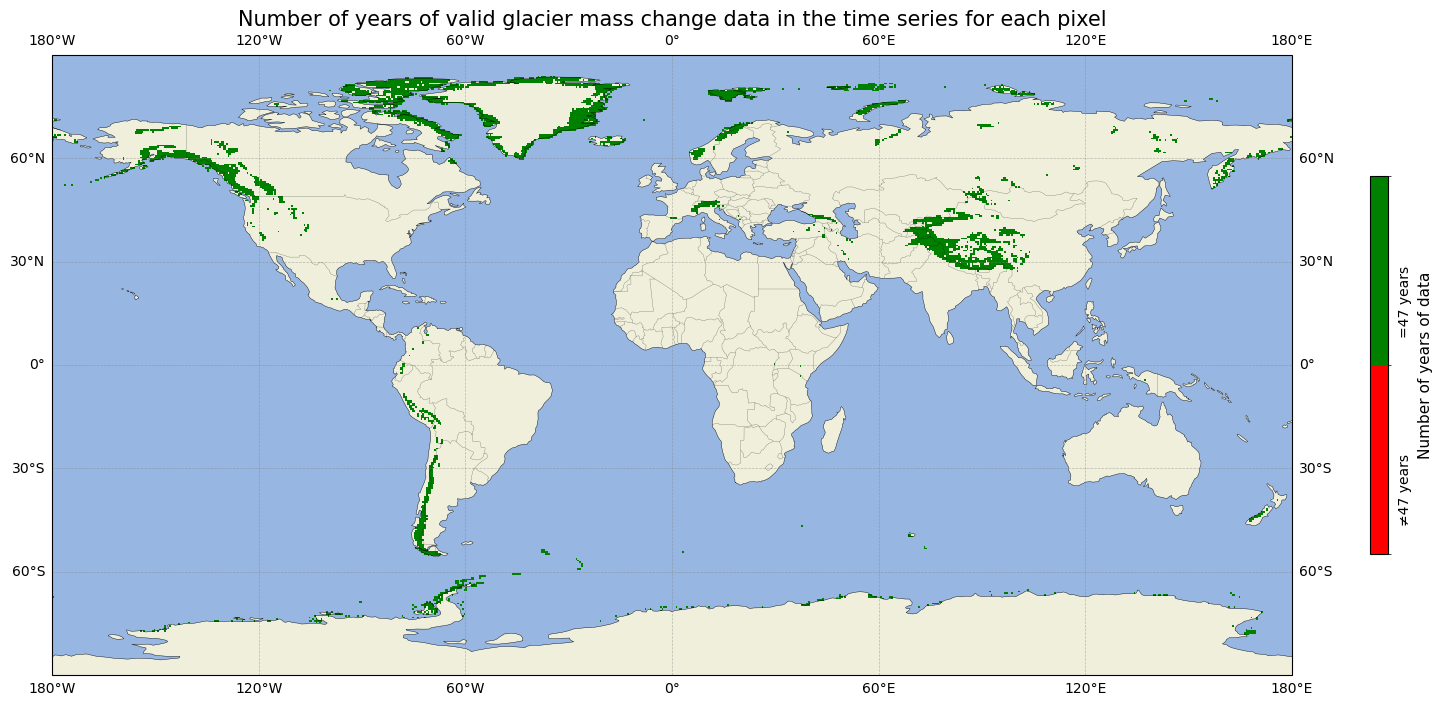

In [442]:
# Define the boundaries for the colorbar
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = mpl.colors.ListedColormap(['red', 'green'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
non_nan_counts = ds["glacier_mass_change_gt"].count(dim="time").where(ds["glacier_mass_change_gt"].count(dim="time") != 0)
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, non_nan_counts, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Number of years of data', spacing="uniform")
cb.set_ticks([0.25, 0.75])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels([f'≠{np.shape(ds["time"])[0]} years', f'={np.shape(ds["time"])[0]} years'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Number of years of valid glacier mass change data in the time series for each pixel', fontsize=15)
plt.show()

Let's have this number quantified:

In [450]:
count_time = (non_nan_counts == np.shape(ds['time'])[0]).sum().values
count_nonnan = np.sum(~np.isnan(non_nan_counts).values)
print(f"The number of pixels that have a time series of valid glacier mass change data of {np.shape(ds['time'])[0]} years, which is the total number of years in the dataset, is {(100*count_time/count_nonnan):.2f}%.")

The number of pixels that have a time series of valid glacier mass change data of 47 years, which is the total number of years in the dataset, is 100.00%.


In other words, from the above analysis it becomes clear that the dataset exhibits consistently complete temporal and spatial coverage, which allows for reliable quantifications of global glacier mass change values. The temporal resolution of 1 year is also consitent with the minimal threshold value proposed by GCOS (2022), although the ultimate goal would be to have glacier mass changes at a monthly time scale. Although the numbers above suggest a quality-rich dataset in terms of spatio-temporal coverage, some potential limitations include:
- Data can not be consulted at the individual glacier-scale, instead the data are presented at a 0.5 degree global grid.
- It is impossible to determine the number of glaciers in a particular year for which mass or elevation changes are available. It is hence not possible to determine which regions are under/oversampled in space or time, or to quantify how many glacier mass change data are derived from the glaciological or geodetic methods respectively.
- The hydrological year varies from region to region, meaning that annual values from a pixel or region on the northern hemisphere are temporally not fully consistent with annual values from a pixel or region on the southern hemisphere.
- Data were furthermore measured and generated by different institutes/research groups and from different methods (i.e. the in-situ glaciological and satellite-based geodetic methods). As such, they were (with a high degree of certainty) not compiled in a fully consistent way for the entire dataset.

Now, let us use the glacier mass change data to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring.

### Quantification of glacier-related contributions to global sea level change

With all the information above, we can calculate the contribution of glacier mass changes to global sea level change during the last several decades. We therefore make use of the following formula (e.g. Farinotti et al., 2019):

$
h_{SLE} 
$
[mm] = 
$
1*10^6 * \sum_{i={1976}}^{{{n}}} ((\frac{\Delta V_{i}}{A_{s}})*(\frac{{\rho_{i}}}{\rho_{s}}))
$
with 
$
{\Delta V_{i}} = (-\Delta{M_{i}}) * (\frac{{\rho_{w}}}{\rho_{i}})
$
and where ${A_{s}}$ is the ocean surface area [km²], ${\Delta V_{i}}$ is the cumulative ice volume change [km³] calculated from mass changes $\Delta{M_{i}}$ [Gt], $n$ the total number of years in the time series and $\rho$ the respective densities of water $w$, ice $i$ and the sea $s$ [kg m⁻³]. 

The corresponding uncertainty is given by:

$
\sigma_{h_{SLE}} 
$
[mm] = 
$
1*10^6 * \sqrt{(\frac{1}{A_s} \frac{{\rho_{i}}}{\rho_{s}})^2 \sum_{i={1976}}^{{{n}}} (\sigma_{\Delta{V_{i}}})^2}
$
where $\sigma_{\Delta{V_{i}}}$ is the cumulative volume change uncertainty [km³] calculated from $\sigma_{\Delta{M_{i}}} * (\frac{{\rho_{w}}}{\rho_{i}})$ with $\sigma_{\Delta{M_{i}}}$ in units of [Gt].

This results in:

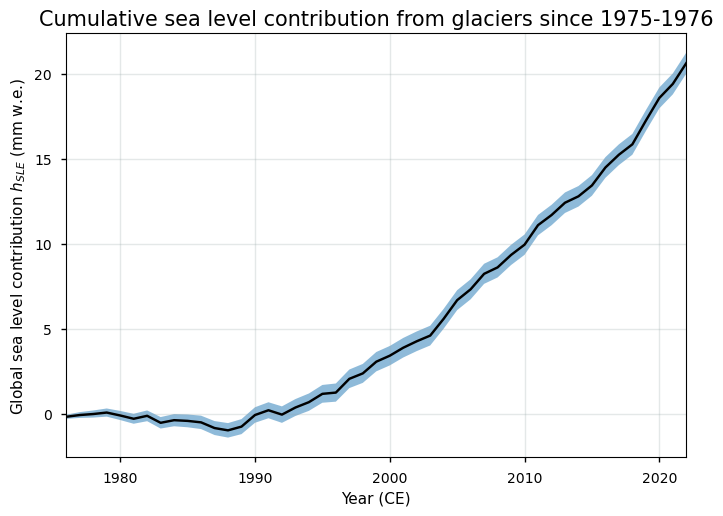

In [458]:
# Define some variables
A_ocean = 3.625E8  # Ocean surface area
p_ice = 917        # Ice density
p_sea = 1028       # Seawater density
p_water = 1000     # Water density
# Calculate global sea level contribution
vol_ice = (ds["Cumulative_gt"])*(p_water/p_ice)           # Volume from Gt to km^3
hsle = -1E6*(vol_ice/(A_ocean))*(p_ice/p_sea)             # Sea level equivalent in mm
hsle_error = 1E6*(((p_ice/p_sea)/(A_ocean))**2*((p_water/p_ice)*ds["Cumulative_error_gt"])**2) ** 0.5
# Plot the data
fig, ax = plt.subplots()
line = hsle
error = hsle_error
ax.fill_between(line["time"], line - error, line + error, alpha=0.5)
line.plot(ax=ax, color="k")
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global sea level contribution $h_{SLE}$ (mm w.e.)")
ax.set_title("Cumulative sea level contribution from glaciers since "+ period_start.replace("_","-"),fontsize=15);
plt.show()

Let us quantify the total glacier-related contribution to global sea level change since the beginning of the dataset:

In [459]:
print(f"The total contribution of glacier mass changes to global sea level change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line.values[-1]:.2f} ± {error.values[-1]:.2f} mm.")

The total contribution of glacier mass changes to global sea level change between 1975-1976 and 2021-2022 is 20.64 ± 0.62 mm.


However, if we want to know the effective contribution of glacier-related mass changes to global sea level changes, we have to take into account several additional processes. That is, glacier ice that is situated already below sea level does not contribute to sea level changes, and also mass changes of floating ice (i.e. lake or marine-terminating glaciers that lose their mass due to frontal ablation) have to be excluded form the calculations (due to the Archimedes' principle). This results in an effective contribution to sea level change (e.g. Farinotti et al., 2019):

$
h_{SLE,eff} 
$
[mm] = 
$
1*10^6 * \sum_{i={1976}}^{{{n}}} ((\frac{\Delta V_{i} - \Delta V_{BSLfl}}{A_{s}})*(\frac{{\rho_{i}}}{\rho_{s}}))
$
with 
$
\Delta V_{BSLfl}
$
the volume of floating glacier ice or glacier ice that is already situated below sea level. 

We therefore create a mask form ERA5 orography that is, however, time-independent (to exclude pixels below sea level), from the ERA5 land-sea mask (that, however, does not exclude ice shelves) and also create a land mask from Cartopy land border geometries to further refine the mask. We then remove all glacier mass changes that occur within the mask form the calculations. Let us check which pixels are removed from the calculation as a result of this mask:

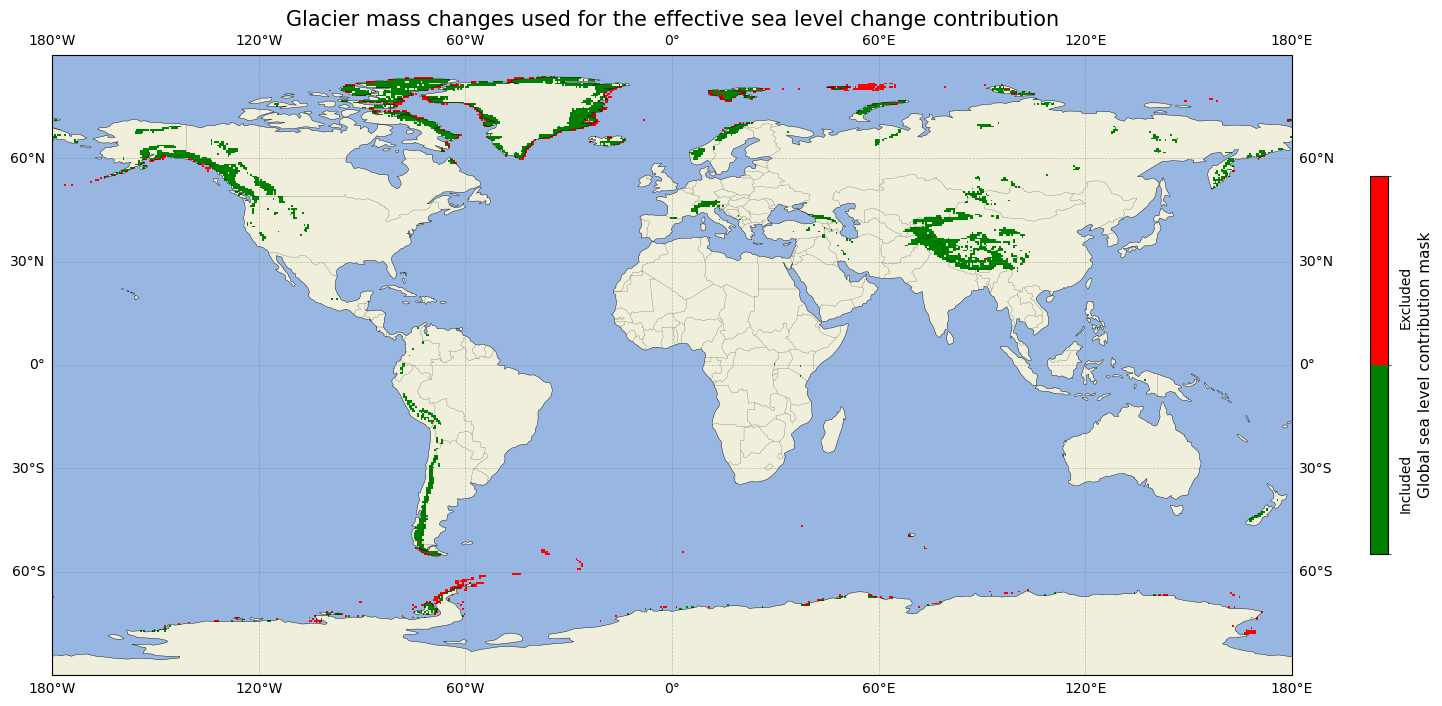

In [546]:
# Define the boundaries for the colorbar
bounds = [0, 0.5, 1]  # Green (0), Red (1)
cmap = mpl.colors.ListedColormap(['green', 'red'])
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
lon_grid, lat_grid = np.meshgrid(ds["longitude"].values, ds["latitude"].values)
fig = plt.figure(figsize=(20, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linewidth=0.25, alpha=0.5)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
mask_included = (mask == 1) & (non_nan_counts>0)
mask_included = np.array(mask_included, dtype=float)
mask_included[np.isnan(error_spatial.values)] = np.nan
# Plot the data
im = ax.pcolormesh(ds["longitude"].values, ds["latitude"].values, mask_included, 
                   transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
cb = fig.colorbar(im, ax=ax, shrink=0.49, label='Global sea level contribution mask', spacing="uniform")
cb.set_ticks([0.25, 0.75])  # Set the ticks at the midpoints of the ranges
cb.set_ticklabels([f'Included', f'Excluded'])  # Set the tick labels
cb.ax.yaxis.set_tick_params(rotation=90)
cb.ax.yaxis.set_tick_params(length=0)
plt.title('Glacier mass changes used for the effective sea level change contribution', fontsize=15)
plt.show()

We can now express this information as a time series to reveal the effective contribution to global sea level change:

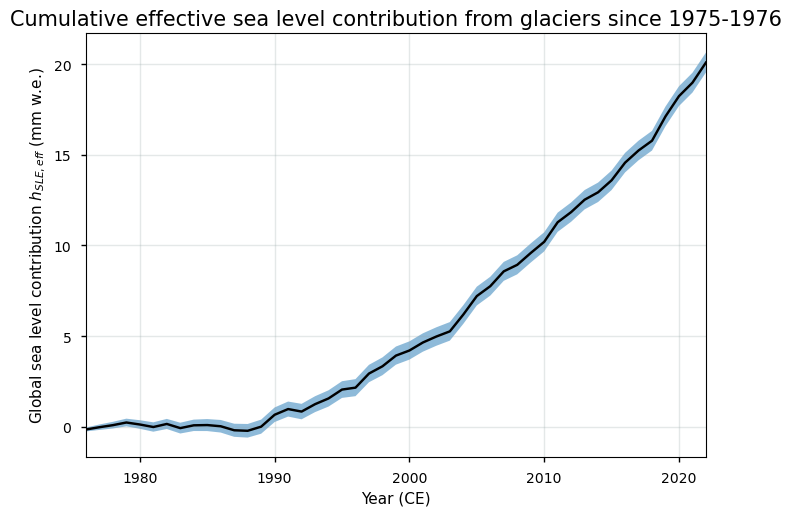

In [463]:
# Create mask for non-contributing mass changes (w.r.t. sea level change)
lons = np.arange(np.min(ds["longitude"].values), np.max(ds["longitude"].values) + 0.5, 0.5)
lats = np.arange(np.min(ds["latitude"].values), np.max(ds["latitude"].values) + 0.5, 0.5)
lon_grid, lat_grid = np.meshgrid(lons, lats)
land_geom = [geom for geom in cfeature.LAND.geometries()]
transform = from_origin(np.min(ds["longitude"].values), np.max(ds["latitude"].values), 0.5, 0.5)
land_mask = rasterio.features.geometry_mask(land_geom, out_shape=lon_grid.shape, transform=transform, all_touched=True)

mask = (orography < 0) | (land_mask > 0.5) | (lsm < 0.5)
time_dim = ds["time"]
mask_expanded = mask.expand_dims({"time": time_dim}, axis=0)
ds["glacier_mass_change_gt"] = xr.where(mask_expanded, 0, ds["glacier_mass_change_gt"])
ds["uncertainty_gt"] = xr.where(mask_expanded, 0, ds["uncertainty_gt"])

# Compute errors and add cumulative glacier mass change
ds_glacier = ds["glacier_mass_change_gt"].sum(("latitude", "longitude"), keep_attrs=True)
ds_error = ((ds['uncertainty_gt']) ** 2).sum(dim=['latitude', 'longitude'],keep_attrs=True) ** 0.5

annual = ds_glacier
annual_err = ds_error
cumulative = ds_glacier.cumsum("time")
cumulative_err = ((ds_error**2).cumsum("time")) ** 0.5

# Add attributes
ds["Cumulative"] = cumulative
ds["Annual"] = annual
ds["Cumulative_error"] = cumulative_err
ds["Annual_error"] = annual_err

# Recalculate the data
vol_ice = (ds["Cumulative"])*(p_water/p_ice)           # Volume from Gt to km^3
hsle = -1E6*(vol_ice/(A_ocean))*(p_ice/p_sea)          # Sea level equivalent in mm
hsle_error = 1E6*(((p_ice/p_sea)/(A_ocean))**2*((p_water/p_ice)*ds["Cumulative_error"])**2) ** 0.5
fig, ax = plt.subplots()
line = hsle
error = hsle_error
ax.fill_between(line["time"], line - error, line + error, alpha=0.5)
line.plot(ax=ax, color="k")
ax.grid(color='#95a5a6',linestyle='-',alpha=0.25)
ax.set_xlim(np.min(ds["time"]),np.max(ds["time"]))
ax.set_xlabel("Year (CE)")
ax.set_ylabel("Global sea level contribution $h_{SLE,eff}$ (mm w.e.)")
ax.set_title("Cumulative effective sea level contribution from glaciers since "+ period_start.replace("_","-"),fontsize=15);plt.show()

Let us again quantify the total effective contribution:

In [466]:
print(f"The total effective contribution of glacier mass changes to global sea level change between {period_start.replace('_', '-')} and {period_stop.replace('_', '-')} is {line.values[-1]:.2f} ± {error.values[-1]:.2f} mm.")

The total effective contribution of glacier mass changes to global sea level change between 1975-1976 and 2021-2022 is 20.08 ± 0.55 mm.


Note that in the above, we were not able to exclude land-locked glaciers (i.e. pixels with glaciers that do not have a direct connectivity to the oceans), nor pixels where meltwater would be stored in terrestrial lakes (and hence also does not reach the ocean).

The glacier mass change product that is on the CDS is thus found to be highly applicable to monitor and derive global (cumulative) mass changes over time and to, for example, assess the corresponding impact on global sea level changes. Because the glacier mass change data are expressed as mass changes in Gt, they can namely be directly converted to global sea level change (if it is assumed that all mass changes contribute to sea level changes, which is not everywhere the case due to part of the glacier ice volume being potentially situated already below sea level, and because of non-contributing floating ice of marine and lake-terminating glaciers). The analysis above points out that the dataset is hence reliable in terms of its accuracy when compared to the minimum GCOS requirements (especially during the more recent years) and its consistency with respect to spatial (i.e. global) and temporal (i.e. since 1975-76 without data gaps) coverage. The data can thus be considered mature with respect to these conditions, confirming the suitability of the glacier mass change dataset to quantify the link between glacier melt and glacier-related contributions to global sea level rise in the context of Earth System modeling and climate change monitoring. However, in order to calculate effective global sea level changes (i.e. to exclude glacier ice below sea level and floating glacier ice), additional information is required for the user. Furthermore, when using the glacier mass change dataset that is available on the CDS, users should be aware of the additional typical problems with the dataset (e.g. the absence of information with respect to the number of sampled glaciers per pixel and year to derive the corresponding glacier mass change value), as earlier discussed in this notebook.

## If you want to know more

### Key resources

- "Glacier mass change gridded data from 1976 to present derived from the Fluctuations of Glaciers Database" on the CDS
- "ERA5 monthly averaged data on single levels from 1940 to present" on the CDS

### References

- Berthier, E., Floriciou, D., Gardner, A.S., Gourmelen, N., Jakob, L., Paul, F., Treichler, D., Wouters, B., Belart, J.M.C., Dehecq, A., Dussaillant, I., Hugonnet, R., Kääb, A., Krieger, L., Pálsson, F., and Zemp, M. (2023). Measuring glacier mass changes from space—a review. Rep. Prog. Phys. 86, 036801. doi:10.1088/1361-6633/acaf8e.

- Bevington, A. R., and Menounos, B. (2022). Accelerated change in the glaciated environments of western Canada revealed through trend analysis of optical satellite imagery. Remote Sensing of Environment, 270, 112862. doi: 10.1016/j.rse.2021.112862.

- Chang, J., Wang, N., Li, Z., and Yang, D. (2022). Accelerated Shrinkage of Glaciers in the Altai Mountains from 2000 to 2020. Front. Earth Sci. 2022, 10, 919051. doi: 10.3389/feart.2022.919051.

- Farinotti, D., Huss, M., Fürst, J. J., Landmann, J., Machguth, H., Maussion, F., and Pandit, A. (2019). A consensus estimate for the ice thickness distribution of all glaciers on Earth. Nature Geoscience, 12(3), 168-173. doi: 10.1038/s41561-019-0300-3.

- GCOS (Global Climate Observing System) (2022). The 2022 GCOS ECVs Requirements (GCOS-245). World Meteorological Organization: Geneva, Switzerland. doi: https://library.wmo.int/idurl/4/58111.

- Maurer, J. M., Schaefer, J. M., Rupper, S., and Corley, A. (2019). Acceleration of ice loss across the Himalayas over the past 40 years. Sci Adv., 2019 Jun 19, 5(6), eaav7266. doi: 10.1126/sciadv.aav7266.

- RGI Consortium (2017). Randolph Glacier Inventory – A Dataset of Global Glacier Outlines: Version 6.0: Technical Report, Global Land Ice Measurements from Space, Colorado, USA. Digital Media. doi: 10.7265/N5-RGI-60.

- Tielidze, L. G., Nosenko, G. A., Khromova, T. E., and Paul, F. (2022). Strong acceleration of glacier area loss in the Greater Caucasus between 2000 and 2020, The Cryosphere, 16, 489–504. doi: 10.5194/tc-16-489-2022.

- WGMS (2022). Fluctuations of Glaciers Database. doi: 10.5904/wgms-fog-2022-09.

- Zemp, M., Huss, M., Thibert, E., Eckert, N., McNabb, R., Huber, J., Barandun, M., Machguth, H., Nussbaumer, S. U., Gärtner-Roer, I., Thomson, L., Paul, F., Maussion, F., Kutuzov, S., and Cogley, J. G. (2019). Global glacier mass changes and their contributions to sea-level rise from 1961 to 2016. Nature, 568, 382–386. doi: 10.1038/s41586-019-1071-0.